In [1]:
%pylab inline
import sys
sys.path.append('/scratch/programming/preprocessing-pipeline/src')
sys.path.append('/scratch/programming/preprocessing-pipeline/in_development/Will')
import pickle
import numpy as np
import xgboost as xgb
import pandas as pd
from cell_extractor.CellDetectorBase import CellDetectorBase
xgb.__version__
from glob import glob

def createDM(df):
    labels=df['label']
    features=df.drop('label',axis=1)
    return xgb.DMatrix(features, label=labels)

def split_data(df,frac=0.5):
    train = pd.DataFrame(df.sample(frac = frac))
    test = df.drop(train.index,axis=0)
    print(train.shape,test.shape,train.index.shape,df.shape)

    trainDM=createDM(train)
    testDM=createDM(test)
    AllDM=createDM(df)
    return trainDM,testDM,AllDM

import pandas as pd

class logger:
    """A helper class for defining a logger function and for parsing the
log, assuming it is created by XGBoost.
    Typical use:

    Logger=logger()
    logall=Logger.get_logger()

    bst = xgb.train(plst, dtrain, num_round, evallist, verbose_eval=False, callbacks=[logall])
    D=Logger.parse_log() #returns a dataframe with the logs.
    """
    def __init__(self):
        self.log=[]
         
    def get_logger(self):
        def logall(*argv,**argc):
            self.log.append(*argv)
        return logall

    def parse_log(self,ax=None):
        """ parse the log and generate plots"""
        D={'iter':[]}
        for _env in self.log:
            current_err={key:val for key,val in _env.evaluation_result_list}
            D['iter'].append(_env.iteration)
            for k in current_err.keys():
                if k in D:
                    D[k].append(current_err[k])
                else:
                    D[k]=[current_err[k]]
        for k in list(D.keys()):
            if len(D[k])==0:
                del D[k]

        df=pd.DataFrame(D)
        df=df.set_index('iter')
        test_col=[c for c in df.columns if 'eval' in c][0]
        print('test column=',test_col)
        _min=df[test_col].min()
        index_min=df[test_col].idxmin()
        title='min of %s=%f at %d'%(test_col,_min,index_min)
        if not ax is None:
            df.plot(grid=True,title=title,ax=ax)  
        return df

def test_xgboost(depth=1,num_round=100):
    param['max_depth']= depth   # depth of tree
    fig, axes = subplots(1,2,figsize=(12,5))
    i=0
    for _eval in ['error','logloss']:
        Logger=logger()
        logall=Logger.get_logger()  # Set logger to collect results
        param['eval_metric'] = _eval 
        bst = xgb.train(param, trainDM, num_round, evallist, verbose_eval=False, callbacks=[logall])
        df=Logger.parse_log(ax=axes[i])
        i+=1
    return bst

def find_corresponding_row_index(all_segment,search_array):
    index_array = []
    i = 0
    for celli in search_array:
        section = celli[2]
        in_section = all_segment[:,2]==section
        segments_in_section = all_segment[in_section,:2]
        diff = segments_in_section[:,:2]-celli[:2]
        dist = np.sqrt(np.sum(np.square(diff),axis=1))
        if len(dist) == 0:
            print(celli)
            print(i)
        cloest_segment = np.argmin(dist)
        corresponding_id = np.where(np.cumsum(in_section)==cloest_segment+1)[0][0]
        if dist[cloest_segment]==0:
            index_array.append(corresponding_id)
        elif dist[cloest_segment]<20:
            index_array.append(corresponding_id)
            print(f'cannot find equal,subbing point with distance: {dist[cloest_segment]}')
        else:
            print('skipping')
            continue
        if i%1000 == 0:
            print(i)
        i+=1
    return index_array

Populating the interactive namespace from numpy and matplotlib


In [2]:
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.3      # shrinkage parameter
param['objective'] = 'binary:logistic'
param['nthread'] = 7 # Number of threads used
param['eval_metric'] = 'logloss' #['error','logloss']

In [7]:
dirs=glob('/net/birdstore/Active_Atlas_Data/cell_segmentation/DK55/CH3/*/DK55*.csv')  
dirs=['/'.join(d.split('/')[:-1]) for d in dirs]
df_list=[]

for dir in dirs:
    filename=glob(dir + '/puntas*.csv')[0]
    df=pd.read_csv(filename)
    df_list.append(df)
len(df_list)
full_df=pd.concat(df_list)
full_df.index=list(range(full_df.shape[0]))
oog=pd.DataFrame(full_df)
drops = ['animal', 'section', 'index', 'row', 'col'] 
oog=oog.drop(drops,axis=1)
trainDM,testDM,allDM=split_data(oog)
evallist = [(trainDM, 'train'), (testDM, 'eval')]

(59095, 41) (59095, 41) (59095,) (118190, 41)


In [9]:
dir = '/net/birdstore/Active_Atlas_Data/cell_segmentation/DK55/all_features.csv'
df = pd.read_csv(dir,index_col = 0)
base = CellDetectorBase('DK55',round=1)
test_counts,train_sections = pickle.load(open(base.QUALIFICATIONS,'rb'))
all_segment = np.array([df.col,df.row,df.section]).T
all_segment_og = np.array([oog.col,oog.row,oog.section]).T

base = CellDetectorBase('DK55',round=1)
test_counts,train_sections = pickle.load(open(base.QUALIFICATIONS,'rb'))
all_segment = np.array([df.col,df.row,df.section]).T

cells = test_counts['computer sure, human unmarked']
cells = np.array([[ci[1]['x'],ci[1]['y'],ci[1]['section']] for ci in cells])
cells_index = find_corresponding_row_index(all_segment,cells)

original = train_sections['original training set after mind change']
original = np.array([[ci[1]['x'],ci[1]['y'],ci[1]['section']] for ci in original])
original_index = find_corresponding_row_index(all_segment,original)

qc_annotation_input_path = '/scratch/programming/preprocessing-pipeline/in_development/yoav/marked_cell_detector/data2/'
neg = qc_annotation_input_path+'/DK55_premotor_manual_negative_round1_2021-12-09.csv'
pos = qc_annotation_input_path+'/DK55_premotor_manual_positive_round1_2021-12-09.csv'
neg = pd.read_csv(neg,header=None).to_numpy()
pos = pd.read_csv(pos,header=None).to_numpy()
positive = find_corresponding_row_index(all_segment,pos)
negative = find_corresponding_row_index(all_segment,neg)

dirs=glob('/net/birdstore/Active_Atlas_Data/cell_segmentation/DK55/CH3/*/DK55*.csv') 
manual_sections = [int(i.split('/')[-2]) for i in dirs]

dir = '/net/birdstore/Active_Atlas_Data/cell_segmentation/DK55/all_features.csv'
df = pd.read_csv(dir,index_col = 0)
labels = np.zeros(len(df))
positive_index = cells_index+original_index+positive
# positive_index = original_index
for i in positive_index:
    labels[i] = 1
df['label'] = labels
# drops = ['animal', 'section', 'index', 'row', 'col'] 
# df=df.drop(drops,axis=1)
# include = [labels[i]==1 or i in negative or all_segment[i,2] in manual_sections for i in range(len(df))]
# include = [labels[i]==1 or all_segment[i,2] in manual_sections for i in range(len(df))]
# df_in_section = df[include]
df_in_section = df

AttributeError: 'DataFrame' object has no attribute 'col'

(400612, 41) (400611, 41) (400612,) (801223, 41)


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



test column= eval-error


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



test column= eval-logloss


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



test column= eval-error


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



test column= eval-logloss


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



test column= eval-error


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



test column= eval-logloss


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



test column= eval-error


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



test column= eval-logloss


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



test column= eval-error


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



test column= eval-logloss


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



test column= eval-error


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



test column= eval-logloss


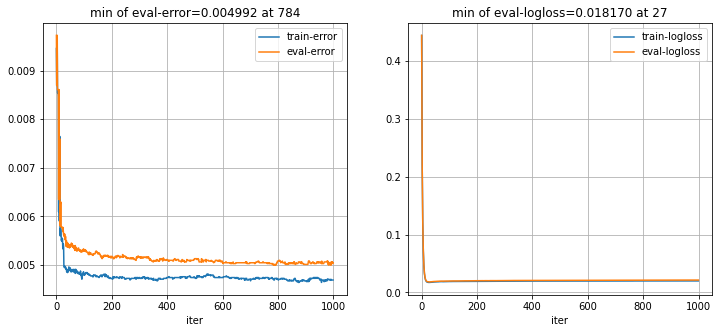

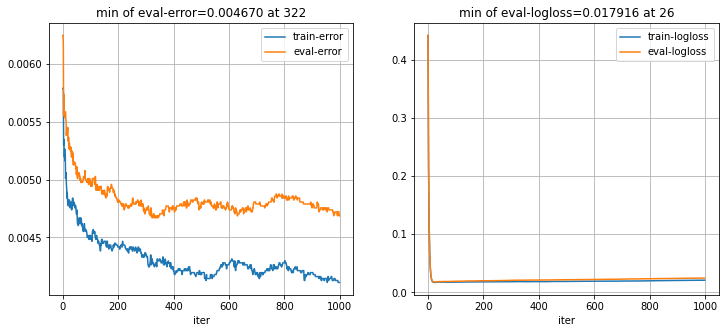

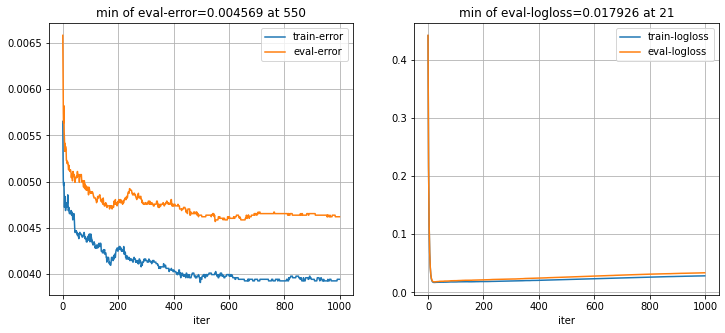

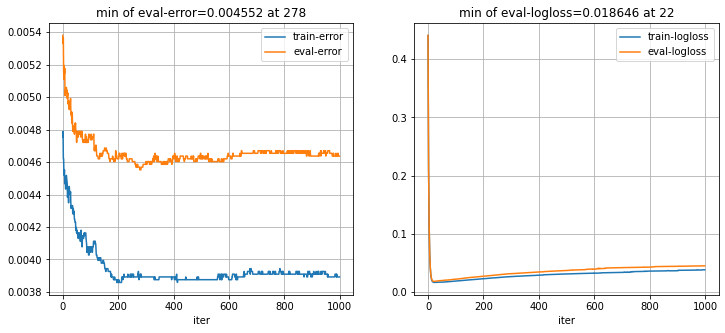

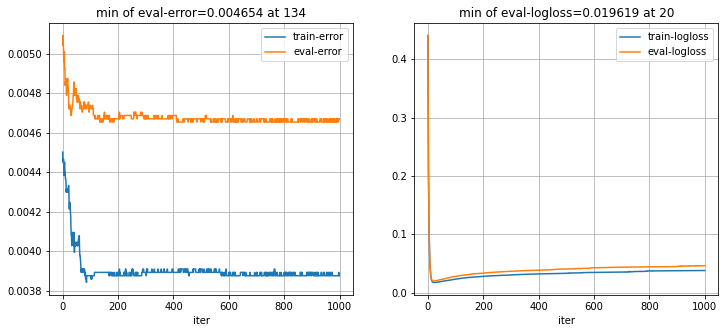

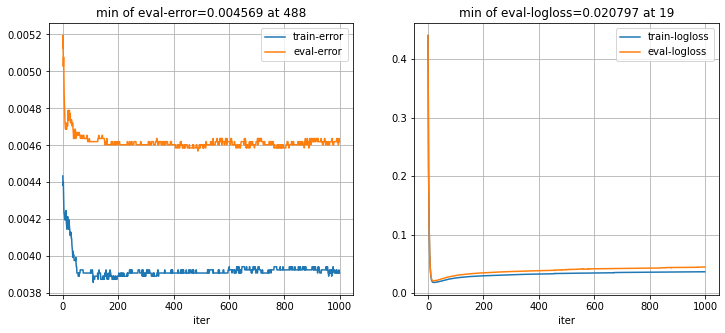

In [ ]:
features = df_in_section
drops = ['animal', 'section', 'index', 'row', 'col'] 
features=features.drop(drops,axis=1)
trainDM,testDM,allDM=split_data(features)
evallist = [(trainDM, 'train'), (testDM, 'eval')]
test_xgboost(depth=1,num_round=1000)
test_xgboost(depth=2,num_round=1000)
test_xgboost(depth=3,num_round=1000)
# test_xgboost(depth=5,num_round=1000)
# test_xgboost(depth=7,num_round=1000)
# test_xgboost(depth=9,num_round=1000)

(59095, 41) (59095, 41) (59095,) (118190, 41)
test column= eval-error
test column= eval-logloss
test column= eval-error
test column= eval-logloss
test column= eval-error
test column= eval-logloss


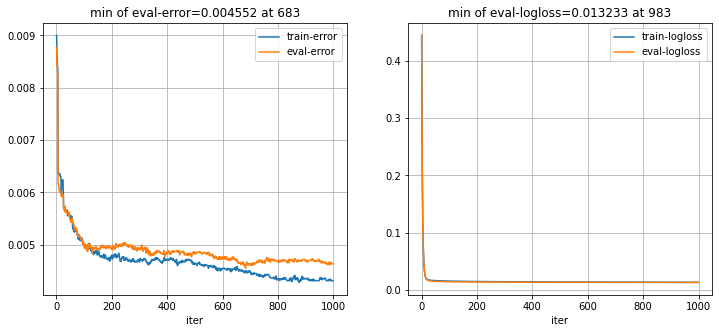

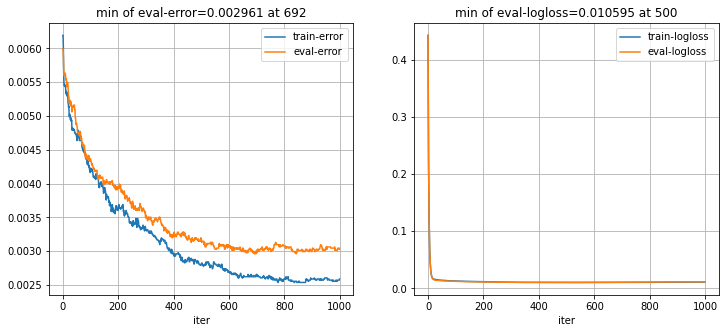

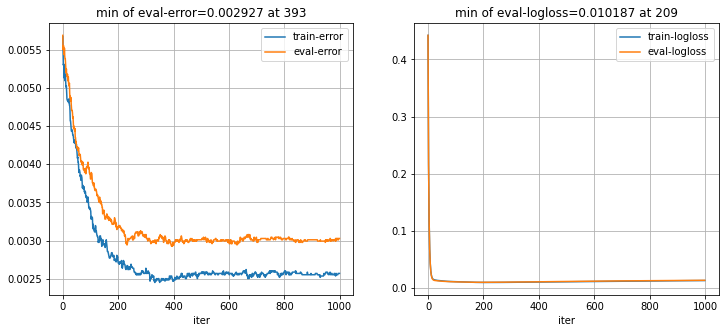

In [8]:
features = oog
trainDM,testDM,allDM=split_data(features)
test_xgboost(depth=1,num_round=1000)
test_xgboost(depth=2,num_round=1000)
test_xgboost(depth=3,num_round=1000)

In [ ]:
for _ in range(3):
    trainDM,testDM,allDM=split_data(df)
    test_xgboost(depth=1,num_round=1000)
    test_xgboost(depth=3,num_round=1000)
    test_xgboost(depth=5,num_round=1000)